# **Homework 5 - Sequence-to-sequence**

2021 年 HW5

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com

- Link to [tutorial]() (TBA).

# Sequence-to-Sequence 介紹
- 大多數常見的 seq2seq model 為 encoder-decoder model，主要由兩個部分組成，分別是 encoder 和 decoder，而這兩個部可以使用 recurrent neural network (RNN)或 transformer 來實作，主要是用來解決輸入和輸出的長度不一樣的情況
- **Encoder** 是將一連串的輸入，如文字、影片、聲音訊號等，編碼為單個向量，這單個向量可以想像為是整個輸入的抽象表示，包含了整個輸入的資訊
- **Decoder** 是將 encoder 輸出的單個向量逐步解碼，一次輸出一個結果，直到將最後目標輸出被產生出來為止，每次輸出會影響下一次的輸出，一般會在開頭加入 "< BOS >" 來表示開始解碼，會在結尾輸出 "< EOS >" 來表示輸出結束


![seq2seq](https://i.imgur.com/0zeDyuI.png)

# 作業介紹
- 英文翻譯中文
  - 輸入： 一句英文 （e.g.		tom is a student .） 
  - 輸出： 中文翻譯 （e.g. 		湯姆 是 個 學生 。）

- TODO
  - 訓練一個 RNN 模型達到 Seq2seq 翻譯
  - 訓練一個 Transformer 大幅提升效能
  - 實作 Back-translation 大幅提升效能

# 下載和引入需要的函式庫

第三方库安装：

```bash
pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
pip install --upgrade jupyter ipywidgets
```

```bash
git clone https://github.com/pytorch/fairseq.git
cd fairseq && git checkout 9a1c497
pip install --upgrade ./fairseq/
```

In [2]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# 設定種子

In [3]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 資料集介紹

## 英轉繁雙語資料
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - 原始資料量: 398,066句    
    - 處理後資料: 393,980句
    

## 測試資料
- 資料量: 4,000句
- **中文部分不公開，提供的檔案為假翻譯，全部都是句點。**

# 資料下載

### 安裝megatools (optional)

In [4]:
#!apt-get install megatools

## 下載檔案並解壓縮

In [ ]:
# 数据位置：/root/yubin/dataset/lhy-homework/ML2021-HW5/rawdata/ted2020

data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A"', 
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214987&authkey=AA4qP_azsicwZZM"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted2020.tgz",
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/test.tgz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U",
#     "https://mega.nz/#!zNcnGIoJ!oPJX9AvVVs11jc0SaK6vxP_lFUNTkEcK2WbxJpvjU5Y",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

## 設定語言

In [5]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = r'/root/yubin/dataset/lhy-homework/ML2021-HW5/rawdata/ted2020/train_dev.raw'
test_prefix = r'/root/yubin/dataset/lhy-homework/ML2021-HW5/rawdata/ted2020/test.raw'

In [7]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## 檔案前處理

In [8]:
import re

def strQ2B(ustring):
    """把字串全形轉半形"""
    # 參考來源:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # 全形空格直接轉換
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # 全形字元（除空格）根據關係轉化
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [9]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/root/yubin/dataset/lhy-homework/ML2021-HW5/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
/root/yubin/dataset/lhy-homework/ML2021-HW5/rawdata/ted2020/test.raw.clean.en & zh exists. skipping clean.


In [10]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## 切出 train/valid set

原来数据集里只有一个文本文件，并没有被划分为 train 和 valid，这里读取 `train_dev.raw.clean.en` 并将其切分为两部分，分别写到 `train.clean.en` 和 `valid.clean.en` 中，中文的 `..zh` 也是这么干。

In [11]:
prefix = Path('/root/yubin/dataset/lhy-homework/ML2021-HW5/rawdata/ted2020')
data_dir = '/root/yubin/dataset/lhy-homework/ML2021-HW5/rawdata'
dataset_name = 'ted2020'

In [12]:
valid_ratio = 0.01 # 3000~4000句就夠了
train_ratio = 1 - valid_ratio

In [13]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
翻譯存在的一大問題是未登錄詞(out of vocabulary)，可以使用 subword units 作為斷詞單位來解決。
- 使用 [sentencepiece](#kudo-richardson-2018-sentencepiece) 套件
- 用 unigram 或 byte-pair encoding (BPE)

这里对英语的划分方法可以参考：[whitespace-is-treated-as-a-basic-symbol](https://github.com/google/sentencepiece#whitespace-is-treated-as-a-basic-symbol)

In [14]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' 也可
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/root/yubin/dataset/lhy-homework/ML2021-HW5/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [15]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/root/yubin/dataset/lhy-homework/ML2021-HW5/rawdata/ted2020/train.en exists. skipping spm_encode.
/root/yubin/dataset/lhy-homework/ML2021-HW5/rawdata/ted2020/train.zh exists. skipping spm_encode.
/root/yubin/dataset/lhy-homework/ML2021-HW5/rawdata/ted2020/valid.en exists. skipping spm_encode.
/root/yubin/dataset/lhy-homework/ML2021-HW5/rawdata/ted2020/valid.zh exists. skipping spm_encode.
/root/yubin/dataset/lhy-homework/ML2021-HW5/rawdata/ted2020/test.en exists. skipping spm_encode.
/root/yubin/dataset/lhy-homework/ML2021-HW5/rawdata/ted2020/test.zh exists. skipping spm_encode.


In [16]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


在上面的数据中，`▁` 部分代表原始句子的一个 space。

## 用 fairseq 將資料轉為 binary

In [17]:
!pwd

/root/sharespace/yubin/github/MLtoys/LHY-HW


In [18]:
binpath = Path('/root/yubin/dataset/lhy-homework/ML2021-HW5/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !/root/miniconda3/envs/LHY/bin/python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

/root/yubin/dataset/lhy-homework/ML2021-HW5/data-bin/ted2020 exists, will not overwrite!


# 實驗的參數設定表

In [19]:
config = Namespace(
    datadir = "/root/yubin/dataset/lhy-homework/ML2021-HW5/data-bin/ted2020",
    savedir = "/root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging 套件紀錄一般訊息
- wandb 紀錄續練過程 loss, bleu, model weight 等等

In [20]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA環境

In [21]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2023-01-20 23:05:59 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2023-01-20 23:05:59 | INFO | fairseq.utils | rank   0: capabilities =  7.5  ; total memory = 44.488 GB ; name = Quadro RTX 8000                         
2023-01-20 23:05:59 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# 讀取資料集

## 借用 fairseq 的 TranslationTask
* 用來讀進上面 binarized 的檔案
* 有現成的 data iterator (dataloader)
* 字典 task.source_dictionary 和 task.target_dictionary 也很好用 
* 有實做 beam search

In [22]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2023-01-20 23:06:09 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2023-01-20 23:06:09 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [32]:
# show the special token
print('eos index:', task.source_dictionary.eos())
print('pad index:', task.source_dictionary.pad())

eos index: 2
pad index: 1


In [23]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2023-01-20 23:06:15 | INFO | hw5.seq2seq | loading data for epoch 1
2023-01-20 23:06:15 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: /root/yubin/dataset/lhy-homework/ML2021-HW5/data-bin/ted2020/train.en-zh.en
2023-01-20 23:06:15 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: /root/yubin/dataset/lhy-homework/ML2021-HW5/data-bin/ted2020/train.en-zh.zh
2023-01-20 23:06:15 | INFO | fairseq.tasks.translation | /root/yubin/dataset/lhy-homework/ML2021-HW5/data-bin/ted2020 train en-zh 390041 examples
2023-01-20 23:06:15 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: /root/yubin/dataset/lhy-homework/ML2021-HW5/data-bin/ted2020/valid.en-zh.en
2023-01-20 23:06:15 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: /root/yubin/dataset/lhy-homework/ML2021-HW5/data-bin/ted2020/valid.en-zh.zh
2023-01-20 23:06:15 | INFO | fairseq.tasks.translation | /root/yubin/dataset/lhy-homework/ML2021-HW5/data-bin/ted2020 valid en-zh 3939 examples


In [24]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  11,   60,   14,    6, 2496,   26,   18,   85,   14,    6,   13, 1616,
        2406,   15,   19,   79,  685,    5, 1243,   52,   92, 1294,    4,   18,
         106,   48,  656,   25,   12, 2453,   98,  142,    4,   11,  880,   98,
         142,    4,   11, 2500,   98,  142,    7,   11,   17,   94, 2745,    4,
          39,  936,    4,   68,  592,   14,    6,  213,  255,  113,    5, 1676,
          94,   15,    8, 1918,  239,    5,  740,    6,   15, 1862, 1833,   11,
        1673,  107,  174,   11,  343,  753,   29,  208,    6,   12,   94,   15,
           8,  770,  239,    7,   11,   17, 1362,    4,  495,  508,   75,  944,
           6,   52, 1732, 1833,  127,  436,   59,    6,    8, 1167,  344,   11,
          13,  274,    6, 2407,    6,   17,  365, 1709,    7,    2]),
 'target': tensor([   5,  718, 1730, 1323,  329,    9, 2812, 1046,  513,    4,    5,  569,
         249,  254,   49,  996, 3341, 1662,   65, 1040,    4, 1035,  254,  248,
          49,  419

In [25]:
# 看看做了啥
s = torch.tensor([11, 60])
task.source_dictionary.string(s)

'▁and ▁what'

## Dataset Iterator

* 將每個 batch 控制在 N 個 token 讓 GPU 記憶體更有效被利用
* 讓 training set 每個 epoch 有不同 shuffling
* 濾掉長度太長的句子
* **將每個 batch 內的句子 pad 成一樣長**，好讓 GPU 平行運算
* `prev_output_tokens` 是 `target` 的 right shift 一格处理的结果，开头是一个 eos
    - teacher forcing: 為了訓練模型根據prefix生成下個字，decoder的輸入會是輸出目標序列往右shift一格。
    - 一般是會在輸入開頭加個bos token (如下圖)
    - fairseq 則是直接把 eos 挪到 beginning，訓練起來效果其實差不多。例如: 
    ```
    # 輸出目標 (target) 和 Decoder輸入 (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```

![seq2seq](https://i.imgur.com/0zeDyuI.png)

In [33]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2023-01-20 23:14:52 | WARNING | fairseq.tasks.fairseq_task | 2,548 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[558, 3702, 2689, 1084, 255, 2474, 792, 3772, 1931, 3046]


{'id': tensor([3472]),
 'nsentences': 1,
 'ntokens': 11,
 'net_input': {'src_tokens': tensor([[   1,    1,    1,    1,    1,    1,    1,   24,  296,  338,   12, 1986,
            698,   20,    7,    2]]),
  'src_lengths': tensor([9]),
  'prev_output_tokens': tensor([[   2,  161,  501,  118,  190,  895, 1031,  234, 1244,  960,    4,    1,
              1,    1,    1,    1]])},
 'target': tensor([[ 161,  501,  118,  190,  895, 1031,  234, 1244,  960,    4,    2,    1,
             1,    1,    1,    1]])}

* 每個 batch 是一個字典，key 是字串，value 是 Tensor，內容說明如下
```python
batch = {
    "id": id, # 每個 example 的 id
    "nsentences": len(samples), # batch size 句子數
    "ntokens": ntokens, # batch size 字數
    "net_input": {
        "src_tokens": src_tokens, # 來源語言的序列
        "src_lengths": src_lengths, # 每句話沒有 pad 過的長度
        "prev_output_tokens": prev_output_tokens, # 上面提到右 shift 一格後的目標序列
    },
    "target": target, # 目標序列
}
```

# 定義模型架構
* 我們一樣繼承 fairseq 的 encoder, decoder 和 model, 這樣測試階段才能直接用他寫好的 beam search 函式

In [34]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Encoder 編碼器

- seq2seq 模型的編碼器為 RNN 或 Transformer Encoder，以下說明以 RNN 為例，Transformer 略有不同。對於每個輸入，Encoder 會輸出一個向量和一個隱藏狀態(hidden state)，並將隱藏狀態用於下一個輸入。換句話說，Encoder 會逐步讀取輸入序列，並在每個 timestep 輸出單個向量，以及在最後 timestep 輸出最終隱藏狀態(content vector)
- 參數:
  - *args*
      - encoder_embed_dim 是 embedding 的維度，主要將 one-hot vector 的單詞向量壓縮到指定的維度，主要是為了降維和濃縮資訊的功用
      - encoder_ffn_embed_dim 是 RNN 輸出和隱藏狀態的維度(hidden dimension)
      - encoder_layers 是 RNN 要疊多少層
      - dropout 是決定有多少的機率會將某個節點變為 0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不使用
  - *dictionary*: fairseq 幫我們做好的 dictionary. 在此用來得到 padding index，好用來得到 encoder padding mask. 
  - *embed_tokens*: 事先做好的詞嵌入 (nn.Embedding)

- 輸入: 
    - *src_tokens*: 英文的整數序列 e.g. 1, 28, 29, 205, 2 
- 輸出: 
    - *outputs*: 最上層 RNN 每個 timestep 的輸出，<u>後續可以用 Attention 再進行處理</u>
    - *final_hiddens*: 每層最終 timestep 的隱藏狀態，將傳遞到 Decoder 進行解碼
    - *encoder_padding_mask*: 告訴我們哪些是位置的資訊不重要。


In [35]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()  # `pad()`: get the index of pad symbol (<pad>) in dictionary.
        
    def combine_bidir(self, outs, bsz: int):
        """
        将 RNN 两个方向得到的 hidden state 拼接到一起
        bsz: batch size
        """
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()  # continuous 是防止接下来再进行 view 操作时出错误，它本身对 tensor 的值没有改变
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        """
        src_tokens: [Batch, Seqlen]
        """
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)  # [B, S, dim]
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # 過雙向RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)  # 方便 h0 的 dtype 和 device 都与 x 一样
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions] 是最上層RNN的輸出
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()  # seq 中的 <pad> 的部分要被之后的处理给 mask 掉
        return tuple(
            (
                outputs,  # seq_len x batch x hidden，后面交给 Attention
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # 這個beam search時會用到，意義並不是很重要
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- 當輸入過長，或是單獨靠 “content vector” 無法取得整個輸入的意思時，用 Attention Mechanism 來提供 Decoder 更多的資訊
- 根據現在 **Decoder embeddings** ，去計算在 **Encoder outputs** 中，那些與其有較高的關係，根據關係的數值來把 Encoder outputs 平均起來作為 **Decoder** RNN 的輸入 
- 常見 Attention 的實作是用 Neural Network / Dot Product 來算 **key** (decoder embeddings) 和 **query** (Encoder outputs) 之間的關係，再對所有算出來的數值做 **softmax** 得到分佈，最後根據這個分佈對 **values** (Encoder outputs) 做 **weight sum**

- 參數:
  - *input_embed_dim*: key 的維度，應是 decoder 要做 attend 時的向量的維度
  - *source_embed_dim*: query 的維度，應是要被 attend 的向量(encoder outputs)的維度
  - *output_embed_dim*: value 的維度，應是做完 attention 後，下一層預期的向量維度

- 輸入: 
    - *inputs*: 就是 key，要 attend 別人的向量
    - *encoder_outputs*: 是 query/value，被 attend 的向量，它来自于 Encoder 最上层 RNN 的输出，shape：[Seqlen, Batch, Hidden]
    - *encoder_padding_mask*: 告訴我們哪些是位置的資訊不重要。
- 輸出: 
    - *output*: 做完 attention 後的 context vector
    - *attention score*: attention 的分布


In [36]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        """

        :param input_embed_dim: Decoder embedding 的 dim，对应于 query
        :param source_embed_dim: Encoder 最上层 RNN 的输出的 hidden dim，它其实是 Encoder self.hidden_dim * 2，因为 encoder 中是双向 RNN。这也是 query 和 value 的 dim
        :param output_embed_dim: context vector 的 dim
        """
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim   这里 T 是指时间长度，即 Decoder 端 input seq 的长度，在一个 sentence 中
        # encoder_outputs: S x B x dim    一条 sentence 的 h_s 就是 S x dim，共 B 个 sentence，这里的 dim 与 inputs 的 dim 不是一个 dim
        # padding mask:  S x B    哪个元素为 1，哪个 token 就被 mask 掉
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # 投影到encoder_outputs的維度
        x = self.input_proj(inputs)  # Attention 的 query，[B. T, dim]

        # 計算attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))  # 每一个元素 score 代表两个 vector 之间的 attention weight

        # 擋住padding位置的attention
        if encoder_padding_mask is not None:
            # 利用broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))   # 不需要关系的部分 attn score 设置为无穷小
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # 在source對應維度softmax
        attn_scores = F.softmax(attn_scores, dim=-1)  # 其实就是正规化，让 score 的分数为 1

        # 形狀 (B, T, S) x (B, S, dim) = (B, T, dim) 加權平均
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)  # x: [B, T, input_embed_dim + source_embed_dim]
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # x: 回復形狀 (B, T, dim) -> (T, B, dim)
        # attn_scores: [B, T, S]
        return x.transpose(1,0), attn_scores

## Decoder 解碼器

* 解碼器的 hidden states 會用編碼器最終隱藏狀態來初始化(content vector)
* 解碼器同時也根據目前 timestep 的輸入(也就是前幾個 timestep 的 output)，改變 hidden states，並輸出結果 
* 如果加入 attention 可以使表現更好
* 我們把 seq2seq 步驟寫在解碼器裡，好讓等等 Seq2Seq 這個型別可以通用 RNN 和 Transformer，而不用再改寫
- 參數:
  - *args*
      - decoder_embed_dim 是解碼器 embedding 的維度，類同 encoder_embed_dim，
      - decoder_ffn_embed_dim 是解碼器 RNN 的隱藏維度，類同 encoder_ffn_embed_dim
      - decoder_layers 解碼器 RNN 的層數
      - share_decoder_input_output_embed 通常 decoder 最後輸出的投影矩陣會和輸入 embedding 共用參數
  - *dictionary*: fairseq 幫我們做好的 dictionary.
  - *embed_tokens*: 事先做好的詞嵌入(nn.Embedding)
- 輸入: 
    - *prev_output_tokens*: 英文的整數序列 e.g. 1, 28, 29, 205, 2 已經 shift 一格的 target
    - *encoder_out*: 編碼器的輸出
    - *incremental_state*: 這是測試階段為了加速，所以會記錄每個 timestep 的 hidden state 詳見 forward
- 輸出: 
    - *outputs*: decoder 每個 timestep 的 logits，還沒經過 softmax 的分布
    - *extra*: 沒用到

In [37]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        
        # 因为 Encoder 中使用了双向 RNN，因此它的最终输出的 hidden_dim 是 encoder_ffn_embed_dim 的 2 倍
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        # self.output_projection: 投影为 vocab 大小的 vector
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],   # embed_dim
                self.embed_tokens.weight.shape[0],   # tgt_vocab_size
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        """在训练中，Decoder 被期待输入整个右移了一位的 target sequence，输出在 vocab 上的 logits.

        :param prev_output_tokens: the entire target sequence(shifted right by one position), begin with the end-of-sentence symbol `dictionary.eos()`, followed by the target sequence
        :type prev_output_tokens: [batch, tgt_len], for teacher forcing.
        :param encoder_out: used for encode-side attention
        :param incremental_state: _description_, defaults to None
        :type incremental_state: _type_, optional
        :return: _description_
        :rtype: _type_
        """
        # 取出encoder的輸出
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # 有上個timestep留下的資訊，讀進來就可以繼續decode，不用從bos重來
            # If the *incremental_state* argument is not ``None`` then we are
            # in incremental inference mode. While *prev_output_tokens* will
            # still contain the entire decoded prefix, we will only use the
            # last step and assume that the rest of the state is cached.
            prev_output_tokens = prev_output_tokens[:, -1:]  # 取每一行的最后一个元素，[batch, 1]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # 沒有incremental state代表這是training或者是test time時的第一步
            # 準備seq2seq: 把encoder_hiddens pass進去decoder的hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # Embed the target sequence, which has been shifted right by one
        # position and now starts with the end-of-sentence symbol `<EOS>`.
        x = self.embed_tokens(prev_output_tokens)  # [B, T, dim]
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # 做decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)  # attention 输出的 x 是经过计算后的 context vector，也就是 value 做 attention weighted sum 的结果

        # 過單向RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # 投影到embedding size (如果hidden 和embed size不一樣，然後share_embedding又設成True,需要額外project一次)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # 投影到vocab size 的分佈
        x = self.output_projection(x)  # [seqlen, batch, vocab_size]
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # 如果是Incremental, 記錄這個timestep的hidden states, 下個timestep讀回來
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # 這個beam search時會用到，意義並不是很重要
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- 由 **Encoder** 和 **Decoder** 組成
- 接收輸入並傳給 **Encoder** 
- 將 **Encoder** 的輸出傳給 **Decoder**
- **Decoder** 根據前幾個 timestep 的輸出和 **Encoder** 輸出進行解碼  
- 當解碼完成後，將 **Decoder** 的輸出傳回 

In [39]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# 模型初始化

In [41]:
# # HINT: transformer 架構
# from fairseq.models.transformer import (
#     TransformerEncoder, 
#     TransformerDecoder,
# )

def build_model(args, task):
    """ 按照參數設定建置模型 """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # 詞嵌入
    # 这里 nn.Embedding 的第三个参数为 padding_idx，假如 seq 为 [3, 4]，padding_idx=0，又规定序列长度统一为 4，那么这个 seq 需要 padding，即 seq = [3, 4, 0, 0]，也就是在原来的 seq 后面补上 0
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # 編碼器與解碼器
    # TODO: 替換成 TransformerEncoder 和 TransformerDecoder
    encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
    decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # 序列到序列模型
    model = Seq2Seq(args, encoder, decoder)
    
    # 序列到序列模型的初始化很重要 需要特別處理
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # 初始化模型
    model.apply(init_params)
    return model

## 設定模型相關參數
參考參數

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|

Strong baseline 用的參數可以參考 [Attention is all you need](#vaswani2017) 的 Table 3 的 transformer-base

In [42]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=512,
    encoder_layers=1,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=1,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# # HINT: 補上Transformer用的參數
# def add_transformer_args(args):
#     args.encoder_attention_heads=4
#     args.encoder_normalize_before=True
    
#     args.decoder_attention_heads=4
#     args.decoder_normalize_before=True
    
#     args.activation_fn="relu"
#     args.max_source_positions=1024
#     args.max_target_positions=1024
    
#     # 補上我們沒有設定的Transformer預設參數
#     from fairseq.models.transformer import base_architecture 
#     base_architecture(arch_args)

# add_transformer_args(arch_args)

In [43]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [44]:
model = build_model(arch_args, task)
logger.info(model)

/root/miniconda3/envs/LHY/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


2023-01-20 23:20:59 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): RNNEncoder(
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (dropout_in_module): Dropout(p=0.3, inplace=False)
    (rnn): GRU(256, 512, dropout=0.3, bidirectional=True)
    (dropout_out_module): Dropout(p=0.3, inplace=False)
  )
  (decoder): RNNDecoder(
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (dropout_in_module): Dropout(p=0.3, inplace=False)
    (rnn): GRU(256, 1024, dropout=0.3)
    (attention): AttentionLayer(
      (input_proj): Linear(in_features=256, out_features=1024, bias=False)
      (output_proj): Linear(in_features=1280, out_features=256, bias=False)
    )
    (dropout_out_module): Dropout(p=0.3, inplace=False)
    (project_out_dim): Linear(in_features=1024, out_features=256, bias=True)
    (output_projection): Linear(in_features=256, out_features=8000, bias=False)
  )
)


# Optimization 最佳化

## Loss: Label Smoothing Regularization
* 讓模型學習輸出較不集中的分佈，防止模型過度自信
* 有時候Ground Truth並非唯一答案，所以在算loss時，我們會保留一部份機率給正確答案以外的label
* 可以有效防止過度擬合

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [45]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，當目標是one-hot時的cross-entropy loss. 以下同 F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        # 將一部分正確答案的機率分配給其他label 所以當計算cross-entropy時等於把所有label的log prob加起來
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # 計算cross-entropy時 加入分配給其他label的loss
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# 一般都用0.1效果就很好了
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root 排程對於訓練 Transformer 時的穩定性很重要，後來也用在 RNN 上。
根據底下公式來更新 learning rate，前期線性增長，後期根據更新步數方根的倒數來遞減。
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$
code [source](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [46]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

## 排程視覺化

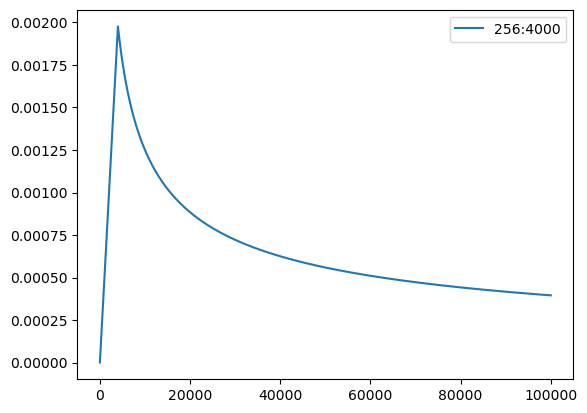

In [47]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# 訓練步驟

## Training 訓練

In [48]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # 梯度累積: 每 accum_steps 個 sample 更新一次
    
    stats = {"loss": []}
    scaler = GradScaler() # 混和精度訓練 automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # 梯度累積: 每 accum_steps 個 sample 更新一次
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # 混和精度訓練 
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # 梯度裁剪 防止梯度爆炸
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference 檢驗和推論
為防止訓練發生過度擬合，每過一段時間要做一次檢測，計算模型在未看過的資料上的表現。
- 過程基本上和training一樣，另外加上 inference
- 檢驗完畢可順便儲存模型參數

單看 validation loss，我們很難知道模型真實的效能
- 直接用當前模型去生成翻譯結果 (hypothesis)，再和正確答案 (reference) 計算 BLEU score
- 也可用肉眼看翻譯結果的好壞
- 我們用 fairseq 寫好的 sequence generator 來進行 beam search 生成翻譯結果

In [49]:
# fairseq 的 beam search generator
# 給定模型和輸入序列，用 beam search 生成翻譯結果
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # 從 Tensor 轉成人看得懂的句子
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # 對於每個 sample, 收集輸入，輸出和參考答案，稍後計算 BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 代表取出 beam 內分數第一的輸出結果
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [50]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # 進行推論
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# 儲存及載入模型參數

In [56]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# 主程式
## 訓練迴圈

In [57]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [58]:
!nvidia-smi

Fri Jan 20 23:37:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     Off  | 00000000:5E:00.0 Off |                    0 |
| N/A   36C    P0    60W / 250W |    974MiB / 46080MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [59]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2023-01-20 23:37:03 | INFO | hw5.seq2seq | task: TranslationTask
2023-01-20 23:37:03 | INFO | hw5.seq2seq | encoder: RNNEncoder
2023-01-20 23:37:03 | INFO | hw5.seq2seq | decoder: RNNDecoder
2023-01-20 23:37:03 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2023-01-20 23:37:03 | INFO | hw5.seq2seq | optimizer: NoamOpt
2023-01-20 23:37:03 | INFO | hw5.seq2seq | num. model params: 11,251,968 (num. trained: 11,251,968)
2023-01-20 23:37:03 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [60]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2023-01-20 23:37:04 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326732]
2023-01-20 23:37:04 | INFO | hw5.seq2seq | no checkpoints found at /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint_last.pt!


train epoch 1:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:38:02 | INFO | hw5.seq2seq | training loss: 7.1110
2023-01-20 23:38:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:38:22 | INFO | hw5.seq2seq | example source: released it on the streets of manhattan .
2023-01-20 23:38:22 | INFO | hw5.seq2seq | example hypothesis: , 我們 , 我們 , 我們 ,  ,  ,  ,  ,  , 你 。
2023-01-20 23:38:22 | INFO | hw5.seq2seq | example reference: 然後把機器人放在曼哈頓的街上 。
2023-01-20 23:38:22 | INFO | hw5.seq2seq | validation loss:	6.5894
2023-01-20 23:38:22 | INFO | hw5.seq2seq | BLEU = 0.11 7.4/0.7/0.1/0.0 (BP = 0.921 ratio = 0.924 hyp_len = 102188 ref_len = 110574)
2023-01-20 23:38:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint1.pt
2023-01-20 23:38:22 | INFO | hw5.seq2seq | end of epoch 1


train epoch 2:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:39:19 | INFO | hw5.seq2seq | training loss: 6.3825
2023-01-20 23:39:19 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:39:35 | INFO | hw5.seq2seq | example source: and he's here also today .
2023-01-20 23:39:35 | INFO | hw5.seq2seq | example hypothesis: 嗯: 「 嗯 。
2023-01-20 23:39:35 | INFO | hw5.seq2seq | example reference: 他本人今天也在場 。
2023-01-20 23:39:35 | INFO | hw5.seq2seq | validation loss:	6.0976
2023-01-20 23:39:35 | INFO | hw5.seq2seq | BLEU = 0.80 20.7/2.6/0.5/0.1 (BP = 0.664 ratio = 0.710 hyp_len = 78467 ref_len = 110574)
2023-01-20 23:39:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint2.pt
2023-01-20 23:39:35 | INFO | hw5.seq2seq | end of epoch 2


train epoch 3:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:40:32 | INFO | hw5.seq2seq | training loss: 5.8596
2023-01-20 23:40:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:40:51 | INFO | hw5.seq2seq | example source: so i stopped hanging out with most of them .
2023-01-20 23:40:51 | INFO | hw5.seq2seq | example hypothesis: 所以 , 我把它們放出來 。
2023-01-20 23:40:51 | INFO | hw5.seq2seq | example reference: 所以我和大多數好友斷絕了關係 。
2023-01-20 23:40:51 | INFO | hw5.seq2seq | validation loss:	5.4661
2023-01-20 23:40:51 | INFO | hw5.seq2seq | BLEU = 1.90 19.9/3.5/0.9/0.3 (BP = 0.953 ratio = 0.954 hyp_len = 105444 ref_len = 110574)
2023-01-20 23:40:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint3.pt
2023-01-20 23:40:51 | INFO | hw5.seq2seq | end of epoch 3


train epoch 4:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:41:49 | INFO | hw5.seq2seq | training loss: 5.4142
2023-01-20 23:41:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:42:09 | INFO | hw5.seq2seq | example source: for example , women have more sexual fantasies about men other than their longterm partner , during the fertile part of the cycle , and that's particularly true if the longterm partner has physical signs of being lower in genetic quality , like he's less physically attractive .
2023-01-20 23:42:09 | INFO | hw5.seq2seq | example hypothesis: 舉例來說 , 大多數人士 , 特別是 , 特別是 , 特別是 , 特別是 , 最重要的是 , 特別是 , 最重要的是 , 最重要的是 , 最重要的是 , 最重要的是 , 最重要的是 , 最重要的是 , 最重要的是 , 最重要的是 , 特別是 , 特別是 , 特別是 , 特別是 , 特別是 , 特別是 , 特別是 , 特別是 , 特別是 , 特別是 , 特別是 , 特別是 , 更糟糕 , 更糟糕 。
2023-01-20 23:42:09 | INFO | hw5.seq2seq | example reference: 比如說 , 女性在排卵期時較常對其他男性有性幻想而較少幻想自己的長期伴侶尤其是當長期伴侶的生理表徵顯示出其基因較不優秀例如外表體態不具吸引力等
2023-01-20 23:42:09 | INFO | hw5.seq2seq | validation loss:	5.0999
2023-01-20 23:42:09 | INFO | hw5.seq2seq | BLEU = 2.66 19.1/4.6/1.4/0.4 (BP = 1.000 ratio = 1.234 hyp_len = 136439 ref_len = 110574)
2023-01-20 23:42:09 | INFO | hw5.seq2seq | saved epoch checkpoin

train epoch 5:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:43:06 | INFO | hw5.seq2seq | training loss: 5.0891
2023-01-20 23:43:06 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:43:25 | INFO | hw5.seq2seq | example source: i'm often asked if i plan to " go back " to ghana .
2023-01-20 23:43:25 | INFO | hw5.seq2seq | example hypothesis: 我常常問我: 「 回到巴西亞 。
2023-01-20 23:43:25 | INFO | hw5.seq2seq | example reference: 我常被問到有沒有 「 回去 」 迦納的打算 。
2023-01-20 23:43:25 | INFO | hw5.seq2seq | validation loss:	4.7072
2023-01-20 23:43:25 | INFO | hw5.seq2seq | BLEU = 8.31 35.8/13.9/6.4/3.1 (BP = 0.836 ratio = 0.848 hyp_len = 93798 ref_len = 110574)
2023-01-20 23:43:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint5.pt
2023-01-20 23:43:26 | INFO | hw5.seq2seq | end of epoch 5


train epoch 6:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:44:22 | INFO | hw5.seq2seq | training loss: 4.7928
2023-01-20 23:44:22 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:44:42 | INFO | hw5.seq2seq | example source: they saw everything .
2023-01-20 23:44:42 | INFO | hw5.seq2seq | example hypothesis: 他們看到所有東西 。
2023-01-20 23:44:42 | INFO | hw5.seq2seq | example reference: 他們看到了一切 。
2023-01-20 23:44:42 | INFO | hw5.seq2seq | validation loss:	4.4475
2023-01-20 23:44:42 | INFO | hw5.seq2seq | BLEU = 10.00 32.1/13.7/6.7/3.4 (BP = 1.000 ratio = 1.112 hyp_len = 122987 ref_len = 110574)
2023-01-20 23:44:42 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint6.pt
2023-01-20 23:44:42 | INFO | hw5.seq2seq | end of epoch 6


train epoch 7:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:45:40 | INFO | hw5.seq2seq | training loss: 4.6055
2023-01-20 23:45:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:46:00 | INFO | hw5.seq2seq | example source: i was wrong .
2023-01-20 23:46:00 | INFO | hw5.seq2seq | example hypothesis: 我錯了 。
2023-01-20 23:46:00 | INFO | hw5.seq2seq | example reference: 但我錯了 。
2023-01-20 23:46:00 | INFO | hw5.seq2seq | validation loss:	4.3251
2023-01-20 23:46:00 | INFO | hw5.seq2seq | BLEU = 11.47 34.4/15.4/7.8/4.2 (BP = 1.000 ratio = 1.103 hyp_len = 122001 ref_len = 110574)
2023-01-20 23:46:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint7.pt
2023-01-20 23:46:00 | INFO | hw5.seq2seq | end of epoch 7


train epoch 8:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:46:58 | INFO | hw5.seq2seq | training loss: 4.4881
2023-01-20 23:46:58 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:47:16 | INFO | hw5.seq2seq | example source: gravity is one thing that we can't see and which we don't understand .
2023-01-20 23:47:16 | INFO | hw5.seq2seq | example hypothesis: 重力是我們無法理解的 。
2023-01-20 23:47:16 | INFO | hw5.seq2seq | example reference: 重力就是一個我們看不見的東西我們也無法理解它
2023-01-20 23:47:16 | INFO | hw5.seq2seq | validation loss:	4.2226
2023-01-20 23:47:16 | INFO | hw5.seq2seq | BLEU = 13.16 39.8/18.7/9.7/5.2 (BP = 0.947 ratio = 0.948 hyp_len = 104832 ref_len = 110574)
2023-01-20 23:47:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint8.pt
2023-01-20 23:47:17 | INFO | hw5.seq2seq | end of epoch 8


train epoch 9:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:48:14 | INFO | hw5.seq2seq | training loss: 4.4023
2023-01-20 23:48:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:48:32 | INFO | hw5.seq2seq | example source: that's the second largest population in the world .
2023-01-20 23:48:32 | INFO | hw5.seq2seq | example hypothesis: 這是世界上第二個大型人口 。
2023-01-20 23:48:32 | INFO | hw5.seq2seq | example reference: 這是世界人第二人口大國的情況
2023-01-20 23:48:32 | INFO | hw5.seq2seq | validation loss:	4.1503
2023-01-20 23:48:32 | INFO | hw5.seq2seq | BLEU = 14.56 41.6/19.9/10.5/5.7 (BP = 0.976 ratio = 0.976 hyp_len = 107949 ref_len = 110574)
2023-01-20 23:48:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint9.pt
2023-01-20 23:48:33 | INFO | hw5.seq2seq | end of epoch 9


train epoch 10:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:49:31 | INFO | hw5.seq2seq | training loss: 4.3385
2023-01-20 23:49:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:49:50 | INFO | hw5.seq2seq | example source: so who are we ? brothers of masculine chimps , sisters of feminine bonobos ? we are all of them , and more .
2023-01-20 23:49:50 | INFO | hw5.seq2seq | example hypothesis: 所以 , 誰是誰 ? 我們都是誰 ? 我們是誰 ? 我們是誰 ? 我們是誰 ? 我們是誰 ? 我們是誰 ? 我們是誰 ? 我們是誰 ? 我們是誰 ?
2023-01-20 23:49:50 | INFO | hw5.seq2seq | example reference: 那我們又是誰 ? 雄黑猩猩的兄弟 。 雌倭黑猩猩的姐妹 。 我們所有的人 , 還有更多 。
2023-01-20 23:49:50 | INFO | hw5.seq2seq | validation loss:	4.1000
2023-01-20 23:49:50 | INFO | hw5.seq2seq | BLEU = 14.87 42.0/20.3/10.8/6.0 (BP = 0.973 ratio = 0.973 hyp_len = 107599 ref_len = 110574)
2023-01-20 23:49:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint10.pt
2023-01-20 23:49:50 | INFO | hw5.seq2seq | end of epoch 10


train epoch 11:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:50:46 | INFO | hw5.seq2seq | training loss: 4.2881
2023-01-20 23:50:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:51:05 | INFO | hw5.seq2seq | example source: the same , when diagnosed at stage four , which is late , is below one percent .
2023-01-20 23:51:05 | INFO | hw5.seq2seq | example hypothesis: 相同的 , 當診斷在階段四歲時 , 只有百分之十四歲 。
2023-01-20 23:51:05 | INFO | hw5.seq2seq | example reference: 如果在第四期 , 也就是很晚期才診斷出來 , 五年存活率是就不到1% 。
2023-01-20 23:51:05 | INFO | hw5.seq2seq | validation loss:	4.0607
2023-01-20 23:51:05 | INFO | hw5.seq2seq | BLEU = 15.57 42.3/20.6/11.0/6.1 (BP = 0.999 ratio = 0.999 hyp_len = 110434 ref_len = 110574)
2023-01-20 23:51:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint11.pt
2023-01-20 23:51:06 | INFO | hw5.seq2seq | end of epoch 11


train epoch 12:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:52:02 | INFO | hw5.seq2seq | training loss: 4.2468
2023-01-20 23:52:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:52:21 | INFO | hw5.seq2seq | example source: and then i traveled with the team , with the world bank team , as more like someone to help out with organizational matters .
2023-01-20 23:52:21 | INFO | hw5.seq2seq | example hypothesis: 接著 , 我和世界銀行團隊合作 , 像是有人幫忙組織物質 。
2023-01-20 23:52:21 | INFO | hw5.seq2seq | example reference: 接著我和團隊一起旅行 , 和世界銀行團隊一起旅行 , 我比較像是協助處理組織事務的人 。
2023-01-20 23:52:21 | INFO | hw5.seq2seq | validation loss:	4.0348
2023-01-20 23:52:21 | INFO | hw5.seq2seq | BLEU = 15.52 45.9/22.6/12.1/6.9 (BP = 0.905 ratio = 0.909 hyp_len = 100495 ref_len = 110574)
2023-01-20 23:52:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint12.pt
2023-01-20 23:52:21 | INFO | hw5.seq2seq | end of epoch 12


train epoch 13:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:53:18 | INFO | hw5.seq2seq | training loss: 4.2119
2023-01-20 23:53:18 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:53:37 | INFO | hw5.seq2seq | example source: when someone who is physically dependent on opioids stops taking them abruptly , that balance is disrupted .
2023-01-20 23:53:37 | INFO | hw5.seq2seq | example hypothesis: 當某人對鴉片類鴉片類鴉片類藥物停止時 , 平衡就被破壞了 。
2023-01-20 23:53:37 | INFO | hw5.seq2seq | example reference: 如果一個人的身體已經在依賴鴉片類藥物 , 卻突然停止這類藥物 , 這種平衡就會中斷 。
2023-01-20 23:53:37 | INFO | hw5.seq2seq | validation loss:	4.0094
2023-01-20 23:53:37 | INFO | hw5.seq2seq | BLEU = 16.03 42.6/21.1/11.4/6.4 (BP = 1.000 ratio = 1.002 hyp_len = 110786 ref_len = 110574)
2023-01-20 23:53:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint13.pt
2023-01-20 23:53:37 | INFO | hw5.seq2seq | end of epoch 13


train epoch 14:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:54:33 | INFO | hw5.seq2seq | training loss: 4.1831
2023-01-20 23:54:33 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:54:52 | INFO | hw5.seq2seq | example source: it presents , not just the complexities found in a procession of different human beings , but the complexities found within each individual person .
2023-01-20 23:54:52 | INFO | hw5.seq2seq | example hypothesis: 它不僅僅是複雜的複雜性 , 而是在每個人身上的複雜性 。
2023-01-20 23:54:52 | INFO | hw5.seq2seq | example reference: 這體現出這件事情的複雜性 , 不僅體現在不同的人群之間 , 也體現在每個獨立的個人之間 。
2023-01-20 23:54:52 | INFO | hw5.seq2seq | validation loss:	3.9968
2023-01-20 23:54:52 | INFO | hw5.seq2seq | BLEU = 15.45 50.2/25.4/13.8/7.9 (BP = 0.799 ratio = 0.817 hyp_len = 90337 ref_len = 110574)
2023-01-20 23:54:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint14.pt
2023-01-20 23:54:52 | INFO | hw5.seq2seq | end of epoch 14


train epoch 15:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:55:47 | INFO | hw5.seq2seq | training loss: 4.1612
2023-01-20 23:55:47 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:56:09 | INFO | hw5.seq2seq | example source: shortly after this incident , harriet decided to tell me , her chemistry teacher , all about it .
2023-01-20 23:56:09 | INFO | hw5.seq2seq | example hypothesis: 很久之後 , 哈莉特決定要告訴我 , 她的化學老師 , 所有關於它 。
2023-01-20 23:56:10 | INFO | hw5.seq2seq | example reference: 事發不久後哈莉特決定把經過通通告訴她的化學老師也就是我
2023-01-20 23:56:10 | INFO | hw5.seq2seq | validation loss:	3.9612
2023-01-20 23:56:10 | INFO | hw5.seq2seq | BLEU = 16.26 44.8/22.2/12.0/6.8 (BP = 0.964 ratio = 0.965 hyp_len = 106673 ref_len = 110574)
2023-01-20 23:56:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint15.pt
2023-01-20 23:56:10 | INFO | hw5.seq2seq | end of epoch 15


train epoch 16:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:57:07 | INFO | hw5.seq2seq | training loss: 4.1335
2023-01-20 23:57:07 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:57:26 | INFO | hw5.seq2seq | example source: one is: if 80 to 90 percent of what we're finding in the ocean of the marine debris that we're finding in the ocean is plastic , then why don't we call it what it is .
2023-01-20 23:57:26 | INFO | hw5.seq2seq | example hypothesis: 第一:如果80%到90%的海洋中發現的海洋中 , 我們發現海洋的海洋中發現的海洋是塑膠 , 那為什麼我們不打電話給它 。
2023-01-20 23:57:26 | INFO | hw5.seq2seq | example reference: 其中之一為:如果我們在海裡找到的垃圾裏百分之80到90都是塑膠那麽乾脆就稱之爲
2023-01-20 23:57:26 | INFO | hw5.seq2seq | validation loss:	3.9461
2023-01-20 23:57:26 | INFO | hw5.seq2seq | BLEU = 16.23 43.1/21.4/11.5/6.5 (BP = 1.000 ratio = 1.017 hyp_len = 112439 ref_len = 110574)
2023-01-20 23:57:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint16.pt
2023-01-20 23:57:26 | INFO | hw5.seq2seq | end of epoch 16


train epoch 17:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:58:25 | INFO | hw5.seq2seq | training loss: 4.1154
2023-01-20 23:58:25 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-20 23:58:44 | INFO | hw5.seq2seq | example source: his name is tom sietas .
2023-01-20 23:58:44 | INFO | hw5.seq2seq | example hypothesis: 他的名字是湯姆.
2023-01-20 23:58:44 | INFO | hw5.seq2seq | example reference: 他叫湯姆.席耶塔斯 ,
2023-01-20 23:58:44 | INFO | hw5.seq2seq | validation loss:	3.9312
2023-01-20 23:58:44 | INFO | hw5.seq2seq | BLEU = 16.66 44.1/21.9/11.8/6.7 (BP = 1.000 ratio = 1.008 hyp_len = 111478 ref_len = 110574)
2023-01-20 23:58:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint17.pt
2023-01-20 23:58:44 | INFO | hw5.seq2seq | end of epoch 17


train epoch 18:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-20 23:59:41 | INFO | hw5.seq2seq | training loss: 4.0958
2023-01-20 23:59:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-21 00:00:00 | INFO | hw5.seq2seq | example source: so people know that it's there .
2023-01-21 00:00:00 | INFO | hw5.seq2seq | example hypothesis: 人們知道它是在那裡的 。
2023-01-21 00:00:00 | INFO | hw5.seq2seq | example reference: 大家要先瞭解玩耍的定義 ,
2023-01-21 00:00:00 | INFO | hw5.seq2seq | validation loss:	3.9221
2023-01-21 00:00:00 | INFO | hw5.seq2seq | BLEU = 16.94 47.3/23.7/13.0/7.5 (BP = 0.930 ratio = 0.932 hyp_len = 103104 ref_len = 110574)
2023-01-21 00:00:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint18.pt
2023-01-21 00:00:00 | INFO | hw5.seq2seq | end of epoch 18


train epoch 19:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-21 00:00:57 | INFO | hw5.seq2seq | training loss: 4.0793
2023-01-21 00:00:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-21 00:01:17 | INFO | hw5.seq2seq | example source: it allows you to do it anonymously , it allows you to do it for free , and it's completely evidencebased .
2023-01-21 00:01:17 | INFO | hw5.seq2seq | example hypothesis: 它允許你去做它 , 它允許你去做它 , 它允許你能做到它 , 完全證據 。
2023-01-21 00:01:17 | INFO | hw5.seq2seq | example reference: 你可以暱名使用它 , 使用它是免費的 , 且它完全是以證據為根據 。
2023-01-21 00:01:17 | INFO | hw5.seq2seq | validation loss:	3.9157
2023-01-21 00:01:17 | INFO | hw5.seq2seq | BLEU = 17.20 46.3/23.5/12.9/7.4 (BP = 0.957 ratio = 0.958 hyp_len = 105912 ref_len = 110574)
2023-01-21 00:01:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint19.pt
2023-01-21 00:01:17 | INFO | hw5.seq2seq | end of epoch 19


train epoch 20:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-21 00:02:17 | INFO | hw5.seq2seq | training loss: 4.0636
2023-01-21 00:02:17 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-21 00:02:40 | INFO | hw5.seq2seq | example source: so , i was in the cape one time , and i typed the word " simplicity , " and i discovered , in this weird , m . night shyamalan way , that i discovered [the] letters , m , i , t . you know the word ?
2023-01-21 00:02:40 | INFO | hw5.seq2seq | example hypothesis: 那時我在《簡易》中找到了 「 簡單 」 , 我發現了 「 簡直 」 , 我發現了 「 簡單 」 , 我發現了 「 簡直 」 , 我發現了 「 簡直 」 , 我發現了 「 簡直 」 , 我發現了 「 簡直 」 , 我發現了 「 簡直 」 , 我發現了 「 簡直 」 , 我發現了 「 簡直 」 , 我發現了 「 簡直 」 ,
2023-01-21 00:02:40 | INFO | hw5.seq2seq | example reference: 有次我在鱈魚角 , 輸入 " 簡單 " 這個字我發現 , 用奇怪的奈特沙馬蘭方式 , 我發現字母 「 m-i-t 」 , 你知道這個字吧 ?
2023-01-21 00:02:40 | INFO | hw5.seq2seq | validation loss:	3.8939
2023-01-21 00:02:40 | INFO | hw5.seq2seq | BLEU = 17.33 45.7/23.0/12.5/7.1 (BP = 0.991 ratio = 0.991 hyp_len = 109592 ref_len = 110574)
2023-01-21 00:02:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint20.pt
2023-01-21 00:02:40 | INFO | hw5.seq2seq | end 

train epoch 21:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-21 00:03:39 | INFO | hw5.seq2seq | training loss: 4.0532
2023-01-21 00:03:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

2023-01-21 00:04:01 | INFO | hw5.seq2seq | example source: they go to church , by which i mean , they do lots of things for free for each other .
2023-01-21 00:04:01 | INFO | hw5.seq2seq | example hypothesis: 他們會去教堂 , 我說的 , 他們有很多東西可以自由彼此 。
2023-01-21 00:04:01 | INFO | hw5.seq2seq | example reference: 我說到他們會上教堂的意思是 , 他們免費的為彼此做很多事 。
2023-01-21 00:04:01 | INFO | hw5.seq2seq | validation loss:	3.8907
2023-01-21 00:04:01 | INFO | hw5.seq2seq | BLEU = 17.17 47.2/23.8/13.0/7.5 (BP = 0.943 ratio = 0.944 hyp_len = 104418 ref_len = 110574)
2023-01-21 00:04:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/yubin/checkpoint/lhy-homework/ML2021-HW5/rnn/checkpoint21.pt
2023-01-21 00:04:01 | INFO | hw5.seq2seq | end of epoch 21


train epoch 22:   0%|          | 0/791 [00:00<?, ?it/s]

2023-01-21 00:04:59 | INFO | hw5.seq2seq | training loss: 4.0350
2023-01-21 00:04:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/23 [00:00<?, ?it/s]

# Submission 繳交檔案

In [ ]:
# 把幾個 checkpoint 平均起來可以達到 ensemble 的效果
checkdir=config.savedir
!python /root/sharespace/yubin/cloned/fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

## 確認生成繳交檔案的模型參數

In [ ]:
# checkpoint_last.pt : 最後一次檢驗的檔案
# checkpoint_best.pt : 檢驗 BLEU 最高的檔案
# avg_last_5_checkpoint.pt:　最5後個檔案平均
try_load_checkpoint(model, name="checkpoint_best.pt")
validate(model, task, criterion, log_to_wandb=False)
None

## 進行預測

In [ ]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # 進行推論
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # 根據 preprocess 時的順序排列
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [ ]:
generate_prediction(model, task)

In [ ]:
raise

# Back-translation

## 訓練一個反向的翻譯模型

1. 將實驗的參數設定表中(config)的source_lang與target_lang互相交換
2. 將實驗的參數設定表中(config)的savedir更改(ex. "./checkpoints/rnn-back")
3. 訓練一個反向模型

## 利用反向模型生成額外資料

### 下載 monolingual data

In [ ]:
mono_dataset_name = 'mono'

In [ ]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted_zh_corpus.deduped.gz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vMNnDShR!4eHDxzlpzIpdpeQTD-htatU_C7QwcBTwGDaSeBqH534",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

### TODO: 清理資料集

1. 將太長、太短的句子移除
2. 統一標點符號

hint: 可以使用clean_s()來協助

### TODO: Subword Units

用反向模型的 spm model 將資料切成 subword units

hint: spm model 的路徑為 DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

### Binarize

使用fairseq將資料轉為binary

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

### TODO: 生成反向翻譯資料

將 binarized data 加入原本的資料夾中並用一個 split_name 取名

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

便可以使用 generate_prediction(model, task, split="split_name")來產生翻譯資料

In [ ]:
# 將 binarized data 加入原本的資料夾中並用一個 split_name 取名
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
# hint: 用反向模型在 split='mono' 上進行預測，生成 prediction_file
# generate_prediction( ... ,split=... ,outfile=... )

### TODO: 產生新的dataset

1. 將翻譯出來的資料與原先的訓練資料結合
2. 使用之前的spm model切出成Subword Units
3. 重新使用fairseq將資料轉為binary

In [ ]:
# 合併剛剛生成的 prediction_file (.en) 以及中文 mono.zh (.zh)
# 
# hint: 在此用剛剛的 spm model 對 prediction_file 進行切斷詞
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# hint: 在此用 fairseq 把這些檔案再 binarize
# binpath = Path('./DATA/data-bin/synthetic')
# src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
# tgt_dict_file = src_dict_file
# monopref = ./DATA/rawdata/mono/mono.tok # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
# if binpath.exists():
#     print(binpath, "exists, will not overwrite!")
# else:
#     !python -m fairseq_cli.preprocess\
#         --source-lang 'zh'\
#         --target-lang 'en'\
#         --trainpref {monopref}\
#         --destdir {binpath}\
#         --srcdict {src_dict_file}\
#         --tgtdict {tgt_dict_file}\
#         --workers 2

In [ ]:
# 這裡用剛剛準備的檔案合併原先 ted2020 來生成最終 back-translation 的資料
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

### TODO: 重新訓練

當已經產生新的資料集

1. 將實驗的參數設定表(config)中的datadir改為新的資料集("./DATA/data-bin/ted2020_with_mono")
2. 將實驗的參數設定表(config)中的source_lang與target_lang設定還原("en", "zh")
3. 將實驗的參數設定表(config)中的savedir更改(ex. "./checkpoints/rnn-bt")
4. 重新訓練

# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html